### 초기 경로 설정 (클래스 이용을 위함)

In [1]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [2]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [3]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [4]:
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:1


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [5]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [6]:
train_images = glob.glob('/data/segmentation/wound/trainset/images/*')
train_labels = glob.glob('/data/segmentation/wound/trainset/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/wound/validationset/images/*')
valid_labels = glob.glob('/data/segmentation/wound/validationset/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 553 elements
My custom valing-dataset has 278 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

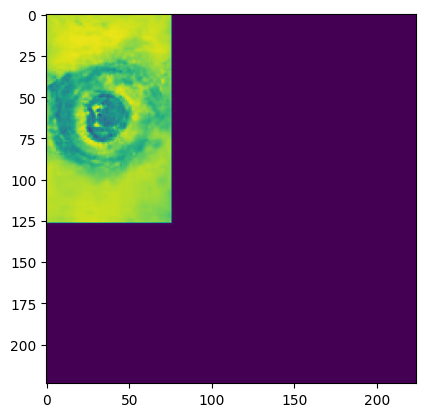

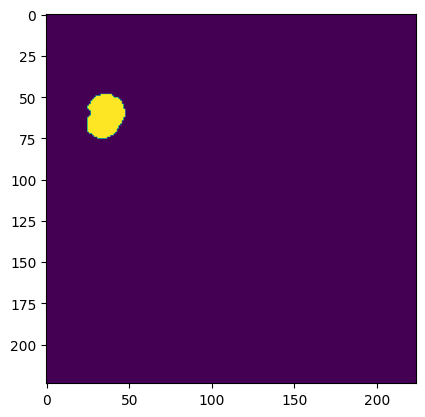

3픽셀의 평균값이라 색깔이 변경됨.


In [7]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [8]:
# Begin training
from models.ColonSegNet import CompNet as ColonSegNet
model = ColonSegNet()
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [9]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [10]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'ColonSegNet'
data_name = 'wound'

# 5. Training

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 70 of 70, Train Loss: 1.280930, IoU: 0.384288, Dice: 0.502244
 Epoch: 1 of 100, Iter.: 70 of 70, Valid Loss: 1.180260, IoU: 0.461135, Dice: 0.551853

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


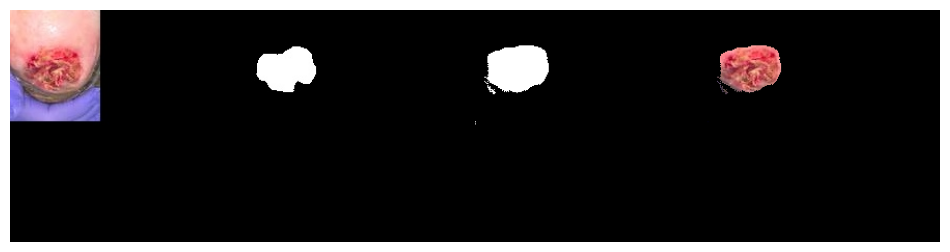

 Epoch: 2 of 100, Iter.: 70 of 70, Train Loss: 1.130709, IoU: 0.536622, Dice: 0.663304
 Epoch: 2 of 100, Iter.: 70 of 70, Valid Loss: 1.099967, IoU: 0.549941, Dice: 0.671726


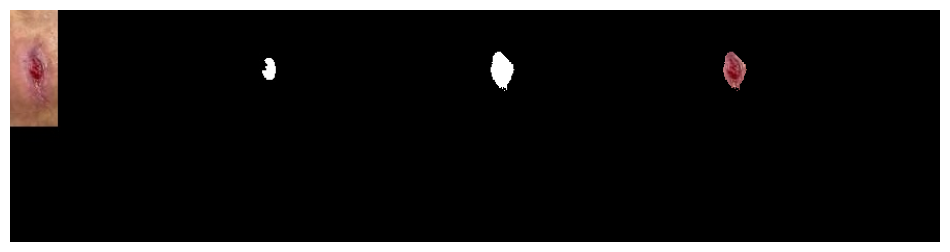

 Epoch: 3 of 100, Iter.: 70 of 70, Train Loss: 1.054835, IoU: 0.562292, Dice: 0.689387
 Epoch: 3 of 100, Iter.: 70 of 70, Valid Loss: 1.029318, IoU: 0.525004, Dice: 0.654847


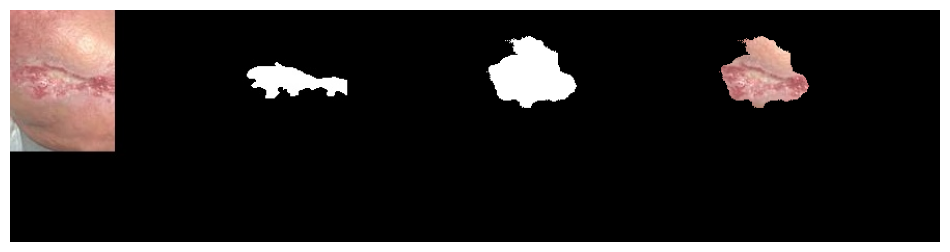

 Epoch: 4 of 100, Iter.: 70 of 70, Train Loss: 0.996055, IoU: 0.574269, Dice: 0.698440
 Epoch: 4 of 100, Iter.: 70 of 70, Valid Loss: 0.977180, IoU: 0.597794, Dice: 0.714312


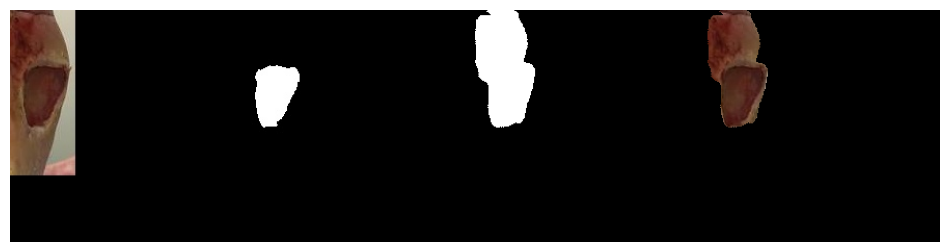

 Epoch: 5 of 100, Iter.: 70 of 70, Train Loss: 0.954122, IoU: 0.570590, Dice: 0.691166
 Epoch: 5 of 100, Iter.: 70 of 70, Valid Loss: 0.931657, IoU: 0.596985, Dice: 0.722348


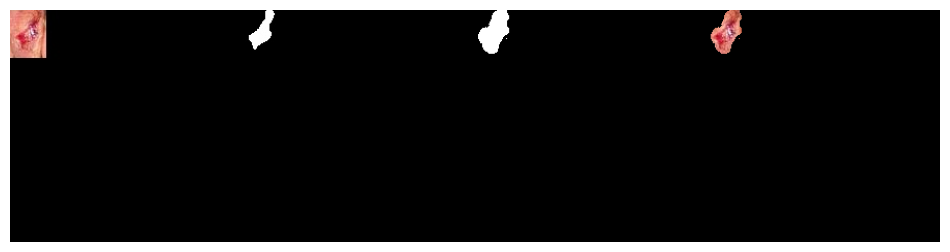

 Epoch: 6 of 100, Iter.: 70 of 70, Train Loss: 0.909097, IoU: 0.595756, Dice: 0.718874
 Epoch: 6 of 100, Iter.: 70 of 70, Valid Loss: 0.919833, IoU: 0.507955, Dice: 0.637169


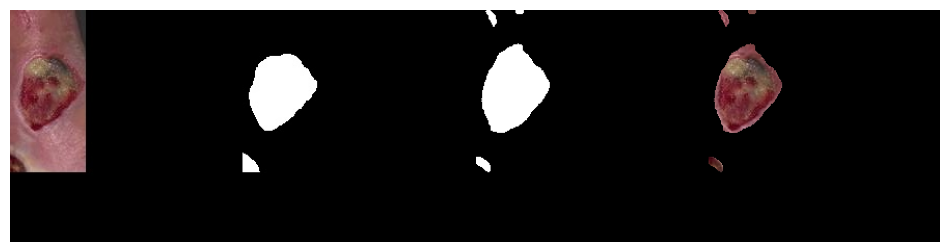

 Epoch: 7 of 100, Iter.: 70 of 70, Train Loss: 0.868355, IoU: 0.595728, Dice: 0.714352
 Epoch: 7 of 100, Iter.: 70 of 70, Valid Loss: 0.856291, IoU: 0.641792, Dice: 0.753257


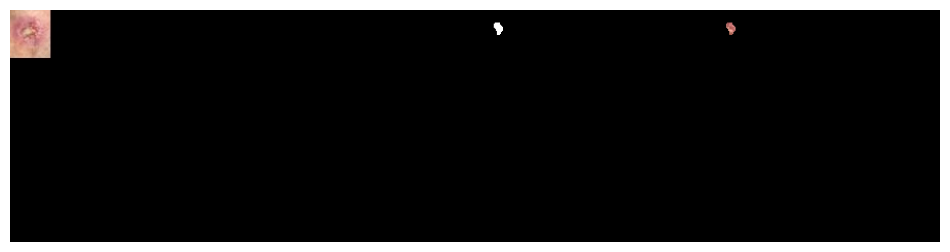

 Epoch: 8 of 100, Iter.: 70 of 70, Train Loss: 0.820005, IoU: 0.624158, Dice: 0.745627
 Epoch: 8 of 100, Iter.: 70 of 70, Valid Loss: 0.804675, IoU: 0.650657, Dice: 0.757909


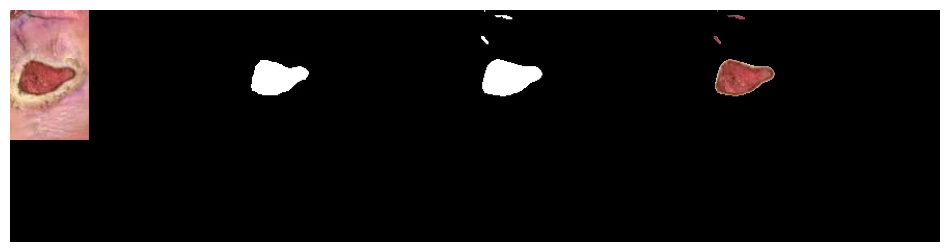

 Epoch: 9 of 100, Iter.: 70 of 70, Train Loss: 0.780863, IoU: 0.618836, Dice: 0.731736
 Epoch: 9 of 100, Iter.: 70 of 70, Valid Loss: 0.816410, IoU: 0.563903, Dice: 0.675807


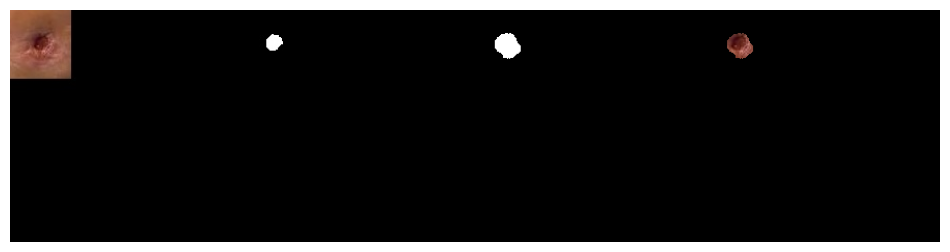

 Epoch: 10 of 100, Iter.: 70 of 70, Train Loss: 0.741958, IoU: 0.618961, Dice: 0.740275
 Epoch: 10 of 100, Iter.: 70 of 70, Valid Loss: 0.747716, IoU: 0.534533, Dice: 0.663535


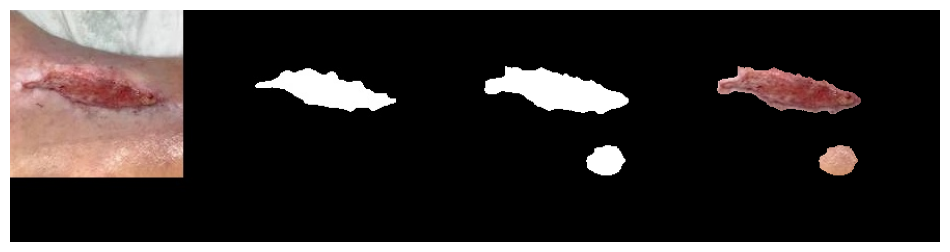

 Epoch: 11 of 100, Iter.: 70 of 70, Train Loss: 0.692804, IoU: 0.635150, Dice: 0.743912
 Epoch: 11 of 100, Iter.: 70 of 70, Valid Loss: 0.698448, IoU: 0.666755, Dice: 0.770909


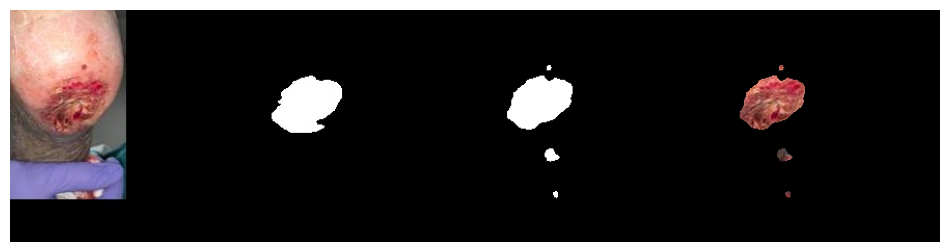

 Epoch: 12 of 100, Iter.: 70 of 70, Train Loss: 0.641995, IoU: 0.659692, Dice: 0.769613
 Epoch: 12 of 100, Iter.: 70 of 70, Valid Loss: 0.638390, IoU: 0.672385, Dice: 0.782908


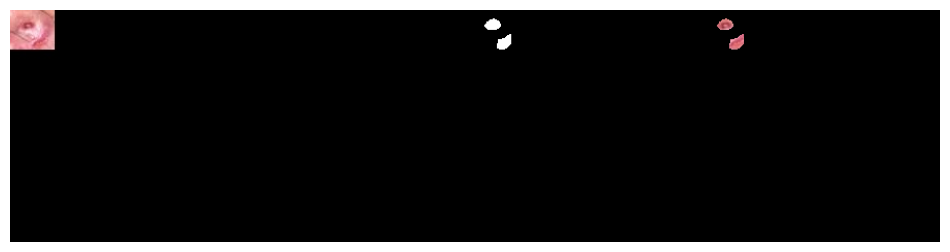

 Epoch: 13 of 100, Iter.: 70 of 70, Train Loss: 0.592833, IoU: 0.675297, Dice: 0.788690
 Epoch: 13 of 100, Iter.: 70 of 70, Valid Loss: 0.591658, IoU: 0.686983, Dice: 0.794919


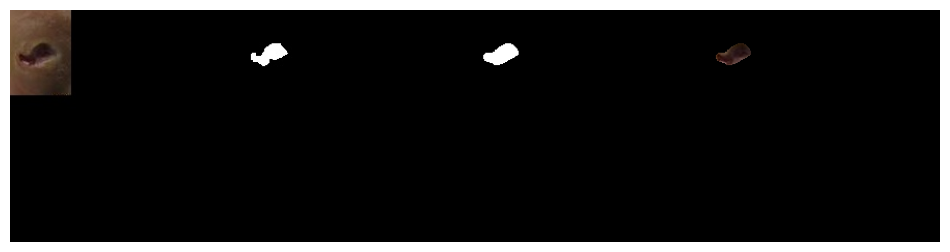

 Epoch: 14 of 100, Iter.: 70 of 70, Train Loss: 0.553829, IoU: 0.672040, Dice: 0.778329
 Epoch: 14 of 100, Iter.: 70 of 70, Valid Loss: 0.531636, IoU: 0.644838, Dice: 0.763562


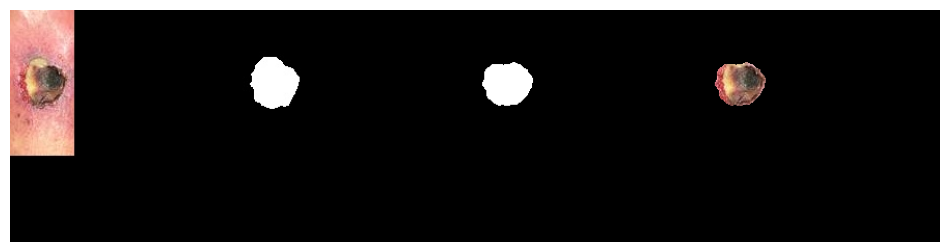

 Epoch: 15 of 100, Iter.: 70 of 70, Train Loss: 0.496149, IoU: 0.685082, Dice: 0.792943
 Epoch: 15 of 100, Iter.: 70 of 70, Valid Loss: 0.492281, IoU: 0.669730, Dice: 0.778088


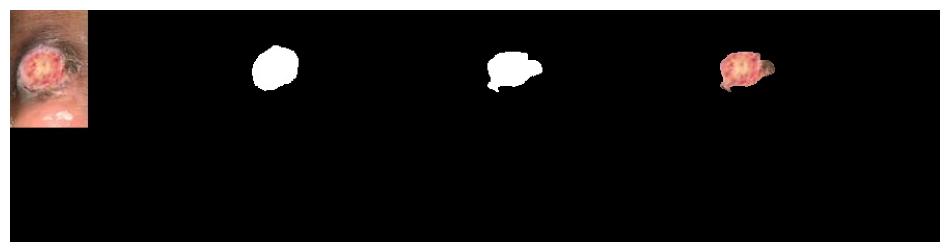

 Epoch: 16 of 100, Iter.: 70 of 70, Train Loss: 0.454447, IoU: 0.693404, Dice: 0.795999
 Epoch: 16 of 100, Iter.: 70 of 70, Valid Loss: 0.457439, IoU: 0.697186, Dice: 0.817452


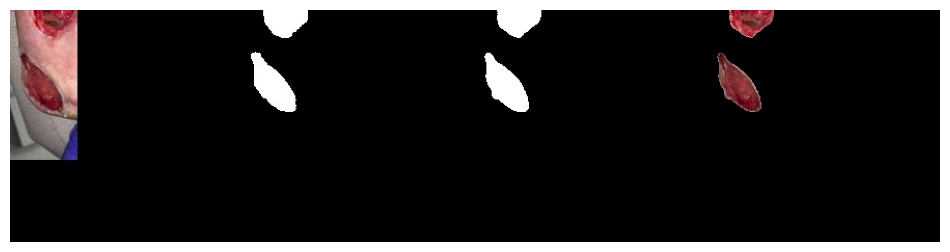

 Epoch: 17 of 100, Iter.: 70 of 70, Train Loss: 0.403091, IoU: 0.701728, Dice: 0.808430
 Epoch: 17 of 100, Iter.: 70 of 70, Valid Loss: 0.403327, IoU: 0.694501, Dice: 0.813278


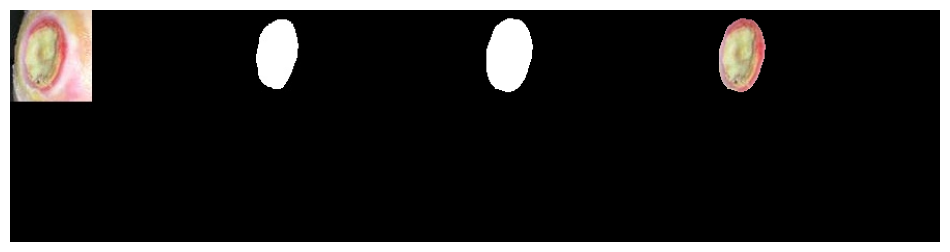

 Epoch: 18 of 100, Iter.: 70 of 70, Train Loss: 0.377677, IoU: 0.708484, Dice: 0.815615
 Epoch: 18 of 100, Iter.: 70 of 70, Valid Loss: 0.377933, IoU: 0.708486, Dice: 0.808114


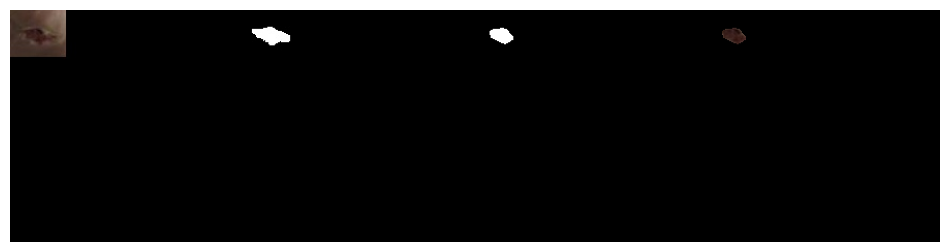

 Epoch: 19 of 100, Iter.: 70 of 70, Train Loss: 0.354259, IoU: 0.708089, Dice: 0.812594
 Epoch: 19 of 100, Iter.: 70 of 70, Valid Loss: 0.359689, IoU: 0.687545, Dice: 0.794221


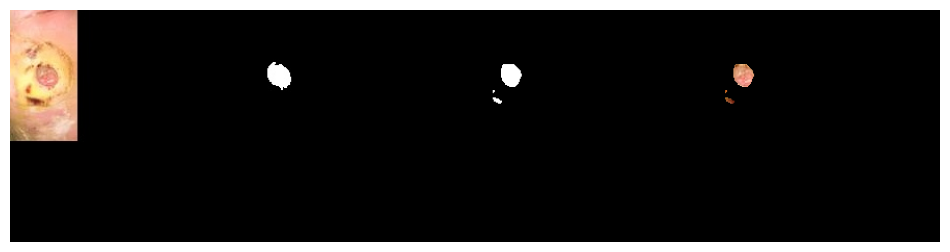

 Epoch: 20 of 100, Iter.: 70 of 70, Train Loss: 0.308158, IoU: 0.726774, Dice: 0.827949
 Epoch: 20 of 100, Iter.: 70 of 70, Valid Loss: 0.378654, IoU: 0.666267, Dice: 0.780435


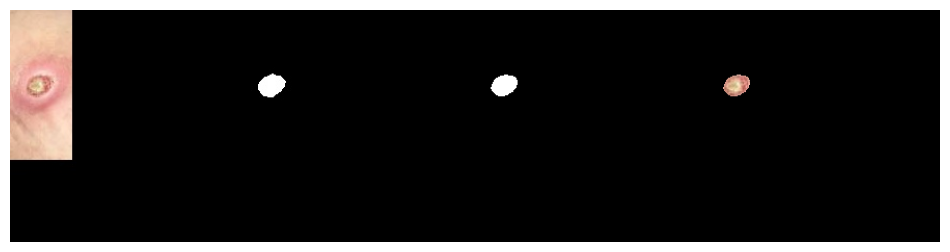

 Epoch: 21 of 100, Iter.: 70 of 70, Train Loss: 0.292278, IoU: 0.731829, Dice: 0.841948
 Epoch: 21 of 100, Iter.: 70 of 70, Valid Loss: 0.352251, IoU: 0.671377, Dice: 0.781710


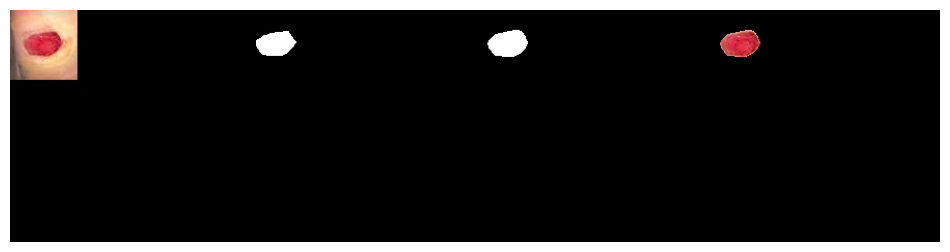

 Epoch: 22 of 100, Iter.: 70 of 70, Train Loss: 0.261842, IoU: 0.747191, Dice: 0.852964
 Epoch: 22 of 100, Iter.: 70 of 70, Valid Loss: 0.289964, IoU: 0.724086, Dice: 0.822200


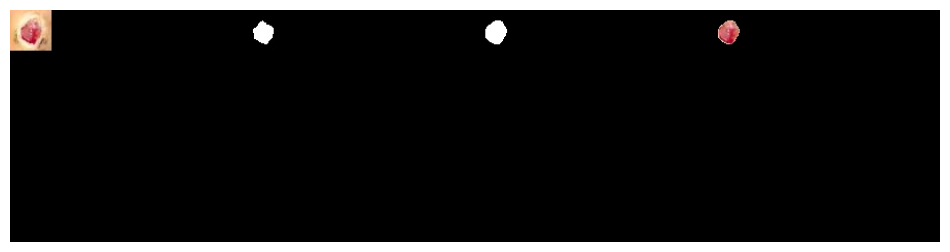

 Epoch: 23 of 100, Iter.: 70 of 70, Train Loss: 0.225971, IoU: 0.759838, Dice: 0.855729
 Epoch: 23 of 100, Iter.: 70 of 70, Valid Loss: 0.291341, IoU: 0.693014, Dice: 0.803429


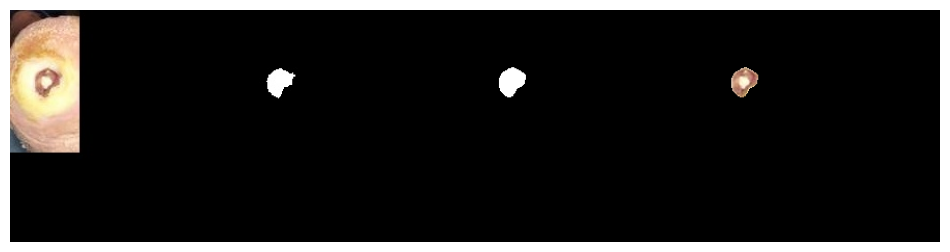

 Epoch: 24 of 100, Iter.: 70 of 70, Train Loss: 0.212959, IoU: 0.770094, Dice: 0.873319
 Epoch: 24 of 100, Iter.: 70 of 70, Valid Loss: 0.315151, IoU: 0.701628, Dice: 0.806190


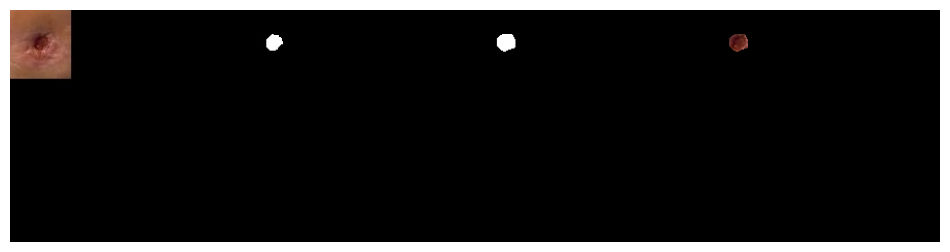

 Epoch: 25 of 100, Iter.: 70 of 70, Train Loss: 0.207710, IoU: 0.757547, Dice: 0.858066
 Epoch: 25 of 100, Iter.: 70 of 70, Valid Loss: 0.260948, IoU: 0.711116, Dice: 0.804619


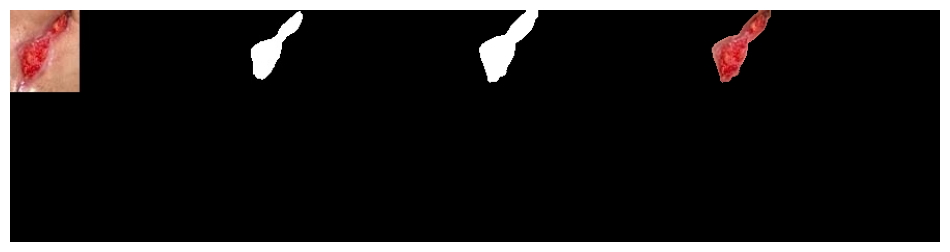

 Epoch: 26 of 100, Iter.: 70 of 70, Train Loss: 0.197241, IoU: 0.772621, Dice: 0.880838
 Epoch: 26 of 100, Iter.: 70 of 70, Valid Loss: 0.251104, IoU: 0.703661, Dice: 0.815032


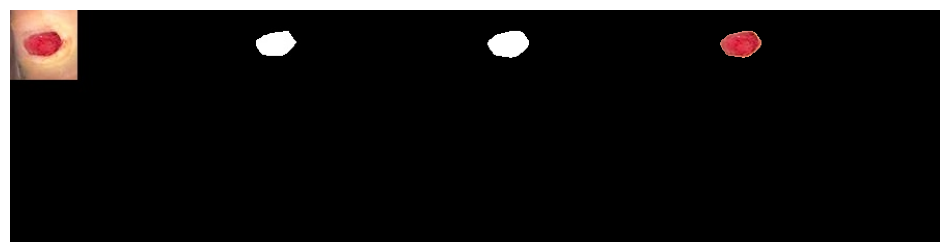

 Epoch: 27 of 100, Iter.: 70 of 70, Train Loss: 0.175342, IoU: 0.792003, Dice: 0.893725
 Epoch: 27 of 100, Iter.: 70 of 70, Valid Loss: 0.262044, IoU: 0.699047, Dice: 0.806834


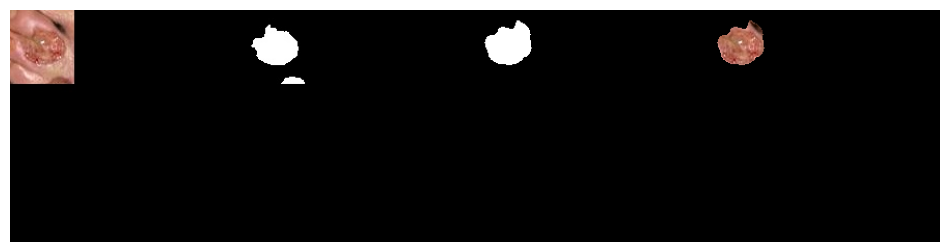

 Epoch: 28 of 100, Iter.: 70 of 70, Train Loss: 0.190795, IoU: 0.750362, Dice: 0.840522
 Epoch: 28 of 100, Iter.: 70 of 70, Valid Loss: 0.325551, IoU: 0.650595, Dice: 0.770023


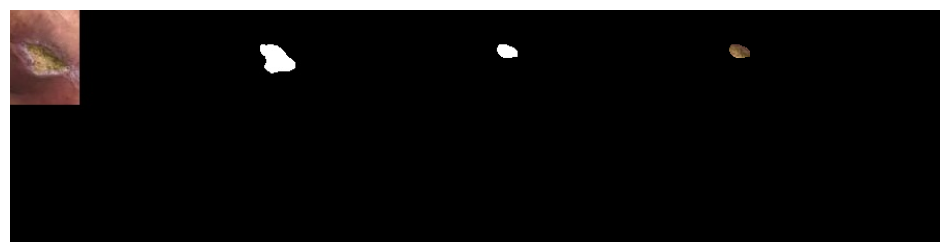

 Epoch: 29 of 100, Iter.: 70 of 70, Train Loss: 0.167076, IoU: 0.775789, Dice: 0.877566
 Epoch: 29 of 100, Iter.: 70 of 70, Valid Loss: 0.305940, IoU: 0.654549, Dice: 0.763879


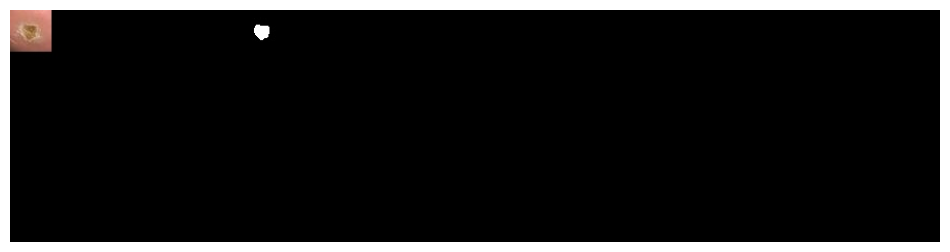

 Epoch: 30 of 100, Iter.: 70 of 70, Train Loss: 0.151229, IoU: 0.786330, Dice: 0.880697
 Epoch: 30 of 100, Iter.: 70 of 70, Valid Loss: 0.222936, IoU: 0.706344, Dice: 0.807817


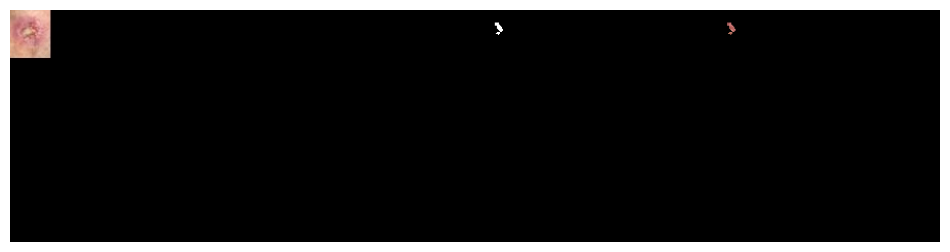

 Epoch: 31 of 100, Iter.: 70 of 70, Train Loss: 0.151284, IoU: 0.784216, Dice: 0.886319
 Epoch: 31 of 100, Iter.: 70 of 70, Valid Loss: 0.210340, IoU: 0.715739, Dice: 0.818301


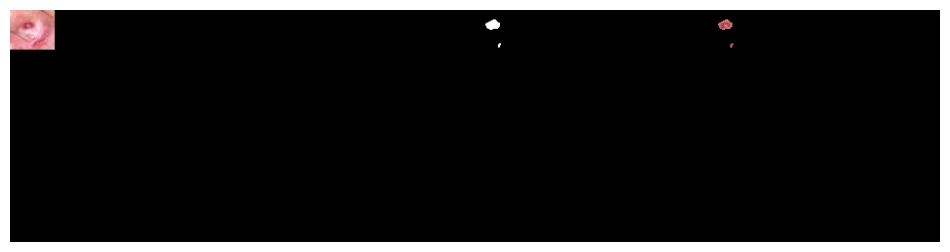

 Epoch: 32 of 100, Iter.: 70 of 70, Train Loss: 0.127269, IoU: 0.810502, Dice: 0.912092
 Epoch: 32 of 100, Iter.: 70 of 70, Valid Loss: 0.199078, IoU: 0.721855, Dice: 0.813160


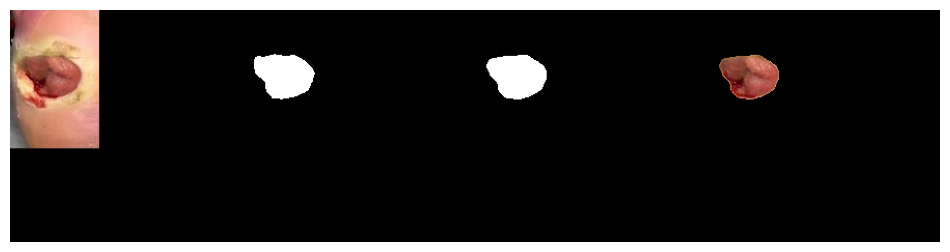

 Epoch: 33 of 100, Iter.: 70 of 70, Train Loss: 0.118528, IoU: 0.823460, Dice: 0.921043
 Epoch: 33 of 100, Iter.: 70 of 70, Valid Loss: 0.198807, IoU: 0.721281, Dice: 0.811487


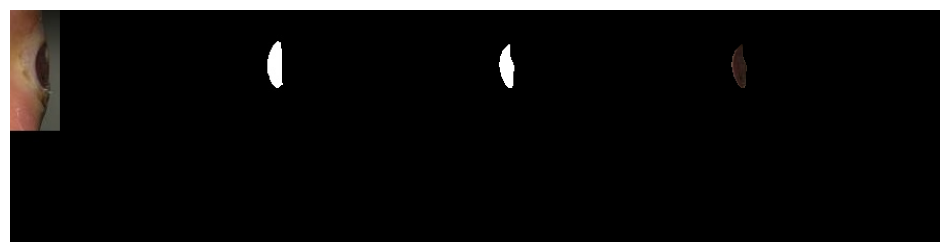

 Epoch: 34 of 100, Iter.: 70 of 70, Train Loss: 0.118451, IoU: 0.827486, Dice: 0.929426
 Epoch: 34 of 100, Iter.: 70 of 70, Valid Loss: 0.204455, IoU: 0.711258, Dice: 0.798756


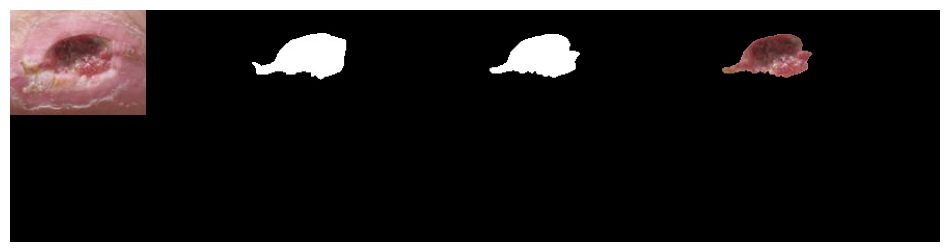

 Epoch: 35 of 100, Iter.: 70 of 70, Train Loss: 0.115392, IoU: 0.819410, Dice: 0.912478
 Epoch: 35 of 100, Iter.: 70 of 70, Valid Loss: 0.205009, IoU: 0.712635, Dice: 0.807931


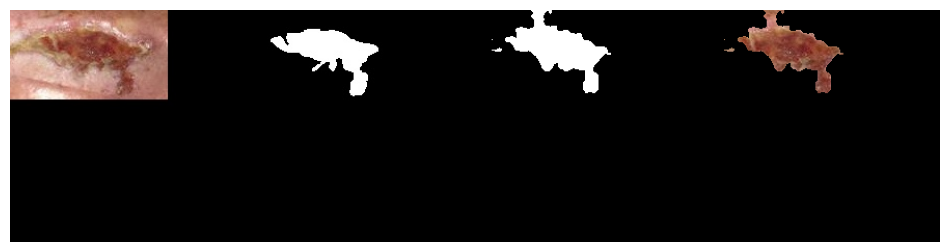

 Epoch: 36 of 100, Iter.: 70 of 70, Train Loss: 0.110331, IoU: 0.828343, Dice: 0.926441
 Epoch: 36 of 100, Iter.: 70 of 70, Valid Loss: 0.207524, IoU: 0.712073, Dice: 0.813433


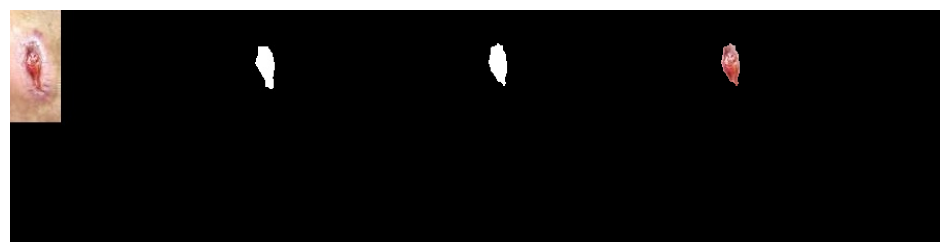

 Epoch: 37 of 100, Iter.: 70 of 70, Train Loss: 0.106524, IoU: 0.835370, Dice: 0.939379
 Epoch: 37 of 100, Iter.: 70 of 70, Valid Loss: 0.230123, IoU: 0.701665, Dice: 0.809879


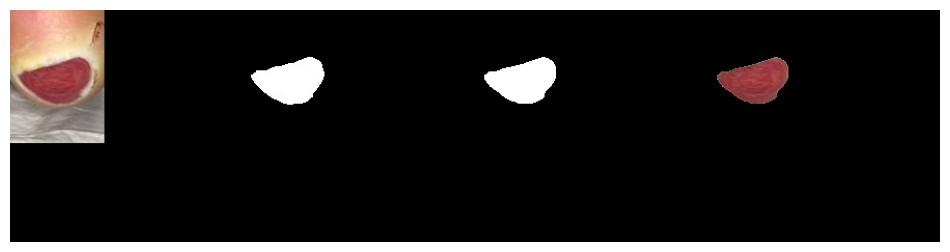

 Epoch: 38 of 100, Iter.: 70 of 70, Train Loss: 0.111199, IoU: 0.816814, Dice: 0.918479
 Epoch: 38 of 100, Iter.: 70 of 70, Valid Loss: 0.245131, IoU: 0.669375, Dice: 0.778622


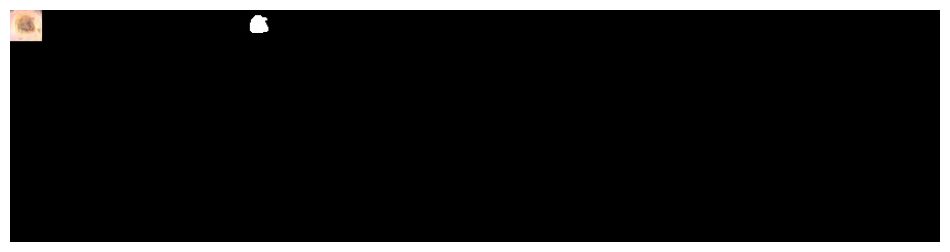

 Epoch: 39 of 100, Iter.: 70 of 70, Train Loss: 0.099146, IoU: 0.840085, Dice: 0.944117
 Epoch: 39 of 100, Iter.: 70 of 70, Valid Loss: 0.191830, IoU: 0.723196, Dice: 0.819487


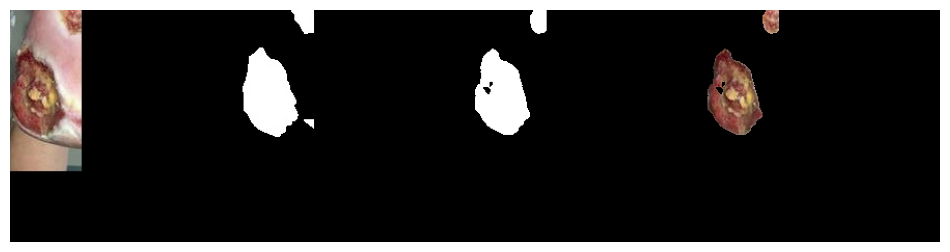

 Epoch: 40 of 100, Iter.: 70 of 70, Train Loss: 0.100926, IoU: 0.837809, Dice: 0.933725
 Epoch: 40 of 100, Iter.: 70 of 70, Valid Loss: 0.242013, IoU: 0.681483, Dice: 0.789918


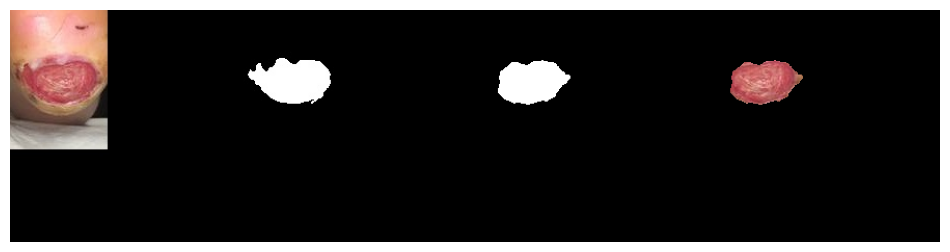

 Epoch: 41 of 100, Iter.: 70 of 70, Train Loss: 0.104141, IoU: 0.829862, Dice: 0.931774
 Epoch: 41 of 100, Iter.: 70 of 70, Valid Loss: 0.184176, IoU: 0.733483, Dice: 0.829961


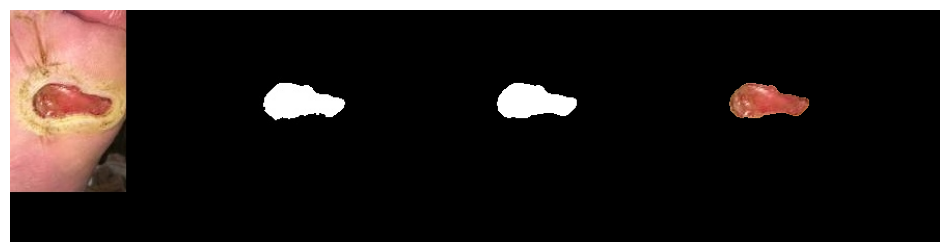

 Epoch: 42 of 100, Iter.: 70 of 70, Train Loss: 0.089682, IoU: 0.852957, Dice: 0.961223
 Epoch: 42 of 100, Iter.: 70 of 70, Valid Loss: 0.185170, IoU: 0.721996, Dice: 0.809137


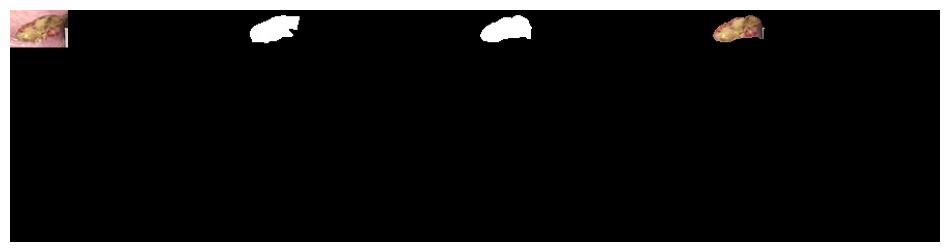

 Epoch: 43 of 100, Iter.: 70 of 70, Train Loss: 0.082309, IoU: 0.860554, Dice: 0.962015
 Epoch: 43 of 100, Iter.: 70 of 70, Valid Loss: 0.202638, IoU: 0.708193, Dice: 0.804982


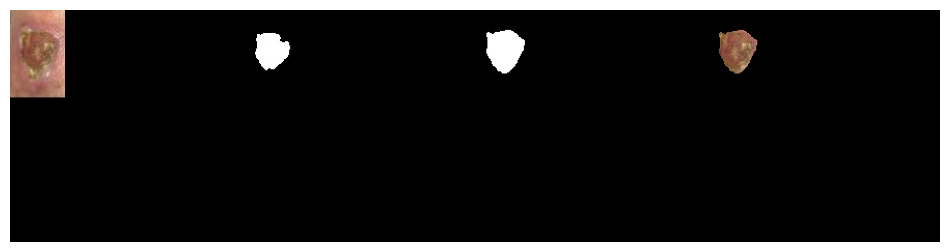

 Epoch: 44 of 100, Iter.: 70 of 70, Train Loss: 0.080073, IoU: 0.868142, Dice: 0.969655
 Epoch: 44 of 100, Iter.: 70 of 70, Valid Loss: 0.201161, IoU: 0.713985, Dice: 0.815949


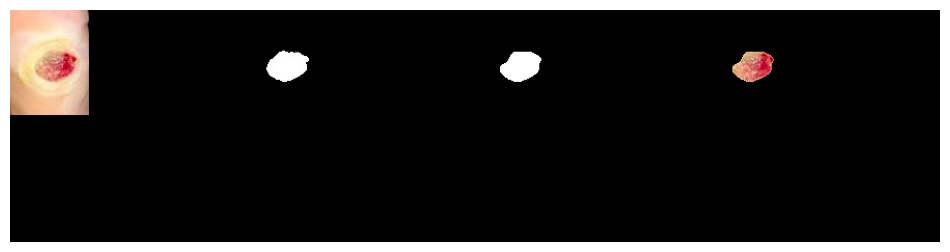

 Epoch: 45 of 100, Iter.: 70 of 70, Train Loss: 0.075306, IoU: 0.865984, Dice: 0.966542
 Epoch: 45 of 100, Iter.: 70 of 70, Valid Loss: 0.193831, IoU: 0.710488, Dice: 0.804648


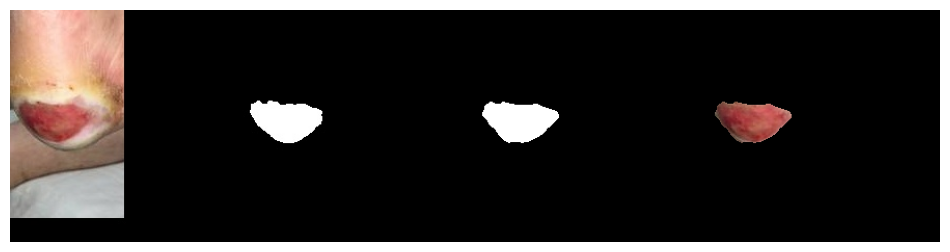

 Epoch: 46 of 100, Iter.: 70 of 70, Train Loss: 0.091323, IoU: 0.852317, Dice: 0.949638
 Epoch: 46 of 100, Iter.: 70 of 70, Valid Loss: 0.190085, IoU: 0.715549, Dice: 0.805056


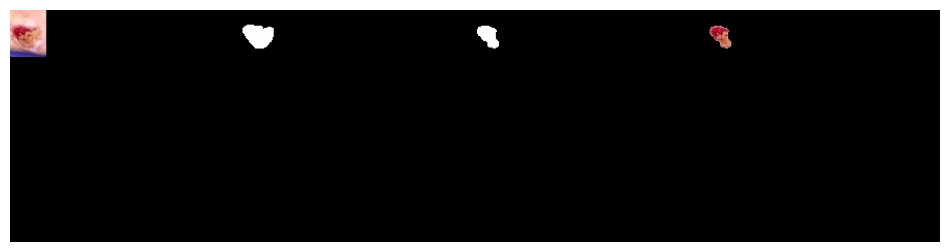

 Epoch: 47 of 100, Iter.: 70 of 70, Train Loss: 0.072881, IoU: 0.870563, Dice: 0.971494
 Epoch: 47 of 100, Iter.: 70 of 70, Valid Loss: 0.206239, IoU: 0.704051, Dice: 0.800106


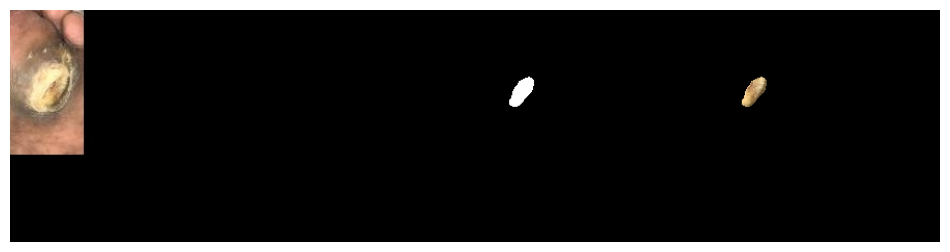

 Epoch: 48 of 100, Iter.: 70 of 70, Train Loss: 0.068333, IoU: 0.881319, Dice: 0.983001
 Epoch: 48 of 100, Iter.: 70 of 70, Valid Loss: 0.186159, IoU: 0.712805, Dice: 0.811387


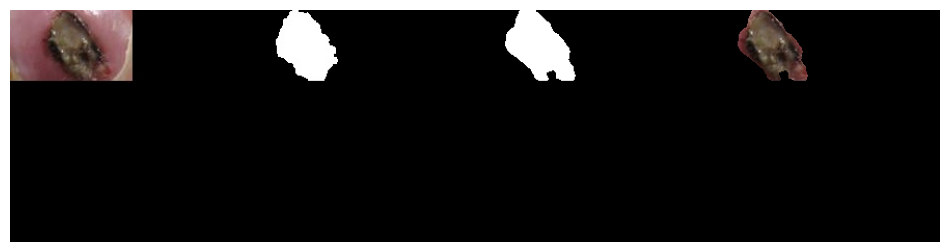

 Epoch: 49 of 100, Iter.: 70 of 70, Train Loss: 0.066704, IoU: 0.882427, Dice: 0.982098
 Epoch: 49 of 100, Iter.: 70 of 70, Valid Loss: 0.173017, IoU: 0.726230, Dice: 0.818437


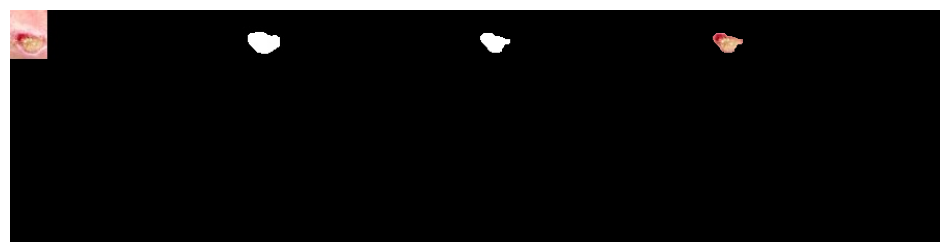

 Epoch: 50 of 100, Iter.: 70 of 70, Train Loss: 0.067853, IoU: 0.883090, Dice: 0.984049
 Epoch: 50 of 100, Iter.: 70 of 70, Valid Loss: 0.200999, IoU: 0.711523, Dice: 0.803879


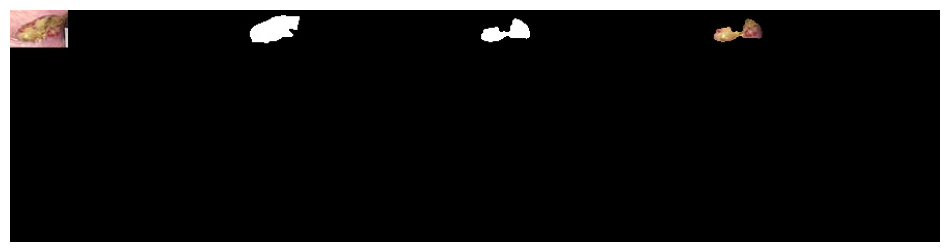

 Epoch: 51 of 100, Iter.: 70 of 70, Train Loss: 0.086787, IoU: 0.835798, Dice: 0.936444
 Epoch: 51 of 100, Iter.: 70 of 70, Valid Loss: 0.206314, IoU: 0.698042, Dice: 0.797216


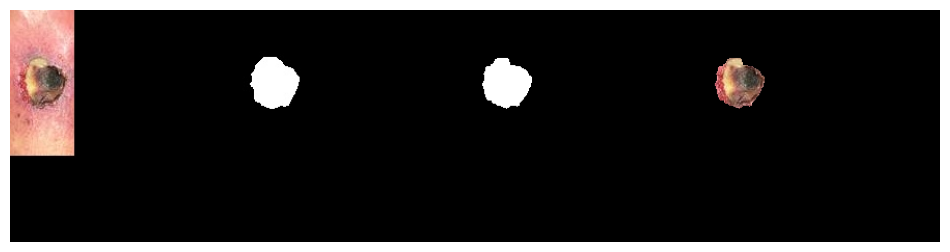

 Epoch: 52 of 100, Iter.: 70 of 70, Train Loss: 0.097436, IoU: 0.817200, Dice: 0.922192
 Epoch: 52 of 100, Iter.: 70 of 70, Valid Loss: 0.209674, IoU: 0.706470, Dice: 0.816115


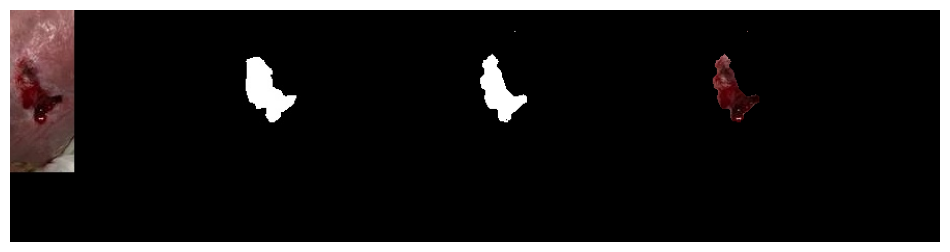

 Epoch: 53 of 100, Iter.: 70 of 70, Train Loss: 0.082525, IoU: 0.846411, Dice: 0.946921
 Epoch: 53 of 100, Iter.: 70 of 70, Valid Loss: 0.190612, IoU: 0.709310, Dice: 0.796893


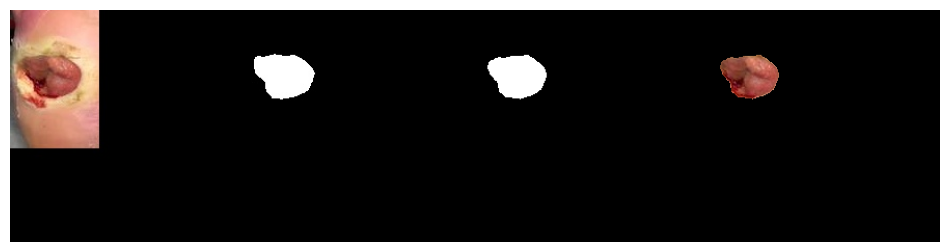

 Epoch: 54 of 100, Iter.: 70 of 70, Train Loss: 0.070764, IoU: 0.874443, Dice: 0.977051
 Epoch: 54 of 100, Iter.: 70 of 70, Valid Loss: 0.209374, IoU: 0.691176, Dice: 0.789933


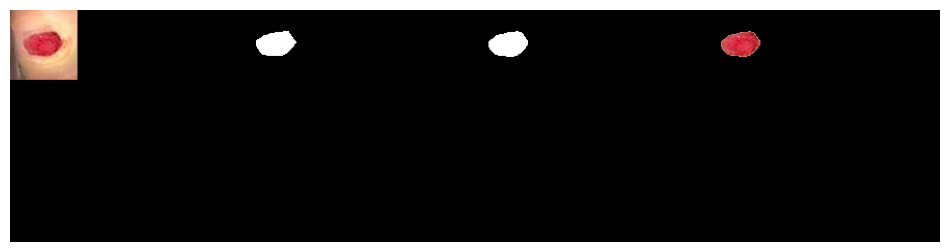

 Epoch: 55 of 100, Iter.: 70 of 70, Train Loss: 0.064042, IoU: 0.881383, Dice: 0.983209
 Epoch: 55 of 100, Iter.: 70 of 70, Valid Loss: 0.207874, IoU: 0.695212, Dice: 0.789188


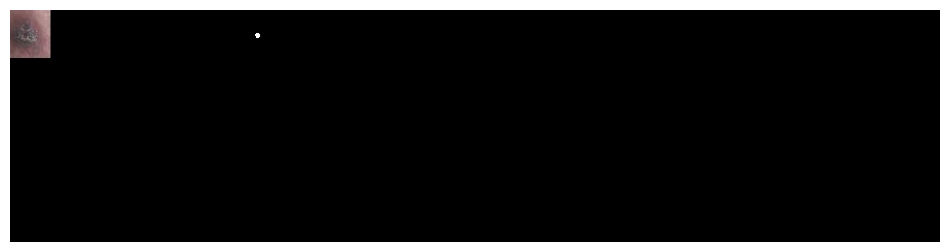

 Epoch: 56 of 100, Iter.: 70 of 70, Train Loss: 0.069350, IoU: 0.877048, Dice: 0.972751
 Epoch: 56 of 100, Iter.: 70 of 70, Valid Loss: 0.199622, IoU: 0.702271, Dice: 0.794836


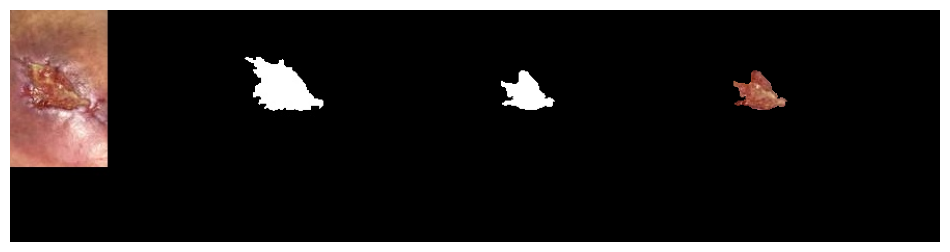

 Epoch: 57 of 100, Iter.: 70 of 70, Train Loss: 0.056295, IoU: 0.894869, Dice: 0.989173
 Epoch: 57 of 100, Iter.: 70 of 70, Valid Loss: 0.186342, IoU: 0.717062, Dice: 0.813908


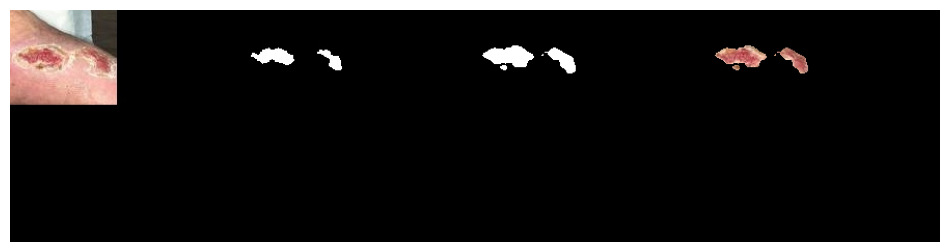

 Epoch: 58 of 100, Iter.: 70 of 70, Train Loss: 0.051604, IoU: 0.900114, Dice: 0.993942
 Epoch: 58 of 100, Iter.: 70 of 70, Valid Loss: 0.192887, IoU: 0.712147, Dice: 0.814548


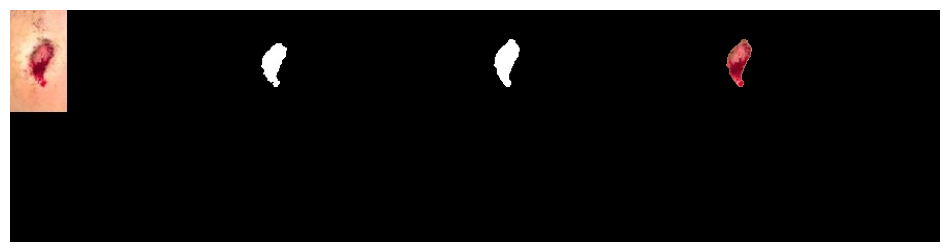

 Epoch: 59 of 100, Iter.: 70 of 70, Train Loss: 0.050293, IoU: 0.901217, Dice: 0.995490
 Epoch: 59 of 100, Iter.: 70 of 70, Valid Loss: 0.183765, IoU: 0.722481, Dice: 0.814854


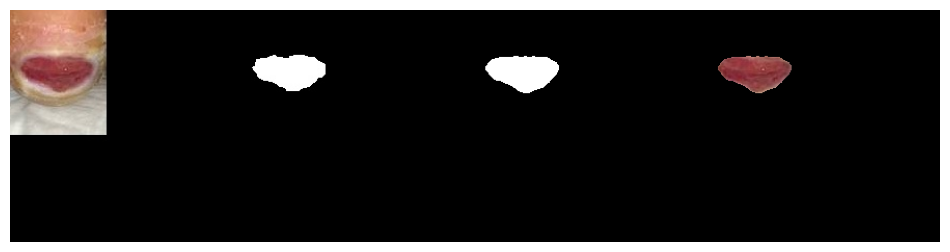

 Epoch: 60 of 100, Iter.: 70 of 70, Train Loss: 0.048629, IoU: 0.910395, Dice: 1.005918
 Epoch: 60 of 100, Iter.: 70 of 70, Valid Loss: 0.184268, IoU: 0.712928, Dice: 0.805821


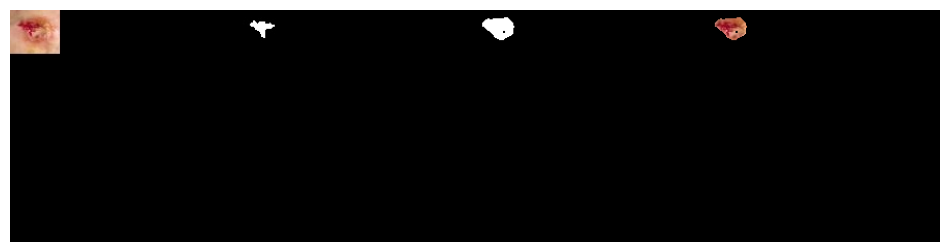

 Epoch: 61 of 100, Iter.: 70 of 70, Train Loss: 0.045823, IoU: 0.909193, Dice: 1.002977
 Epoch: 61 of 100, Iter.: 70 of 70, Valid Loss: 0.187956, IoU: 0.719952, Dice: 0.819755


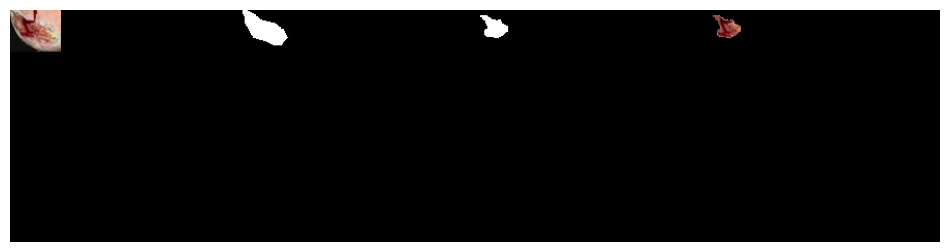

 Epoch: 62 of 100, Iter.: 70 of 70, Train Loss: 0.045651, IoU: 0.913791, Dice: 1.005490
 Epoch: 62 of 100, Iter.: 70 of 70, Valid Loss: 0.185732, IoU: 0.718900, Dice: 0.822940


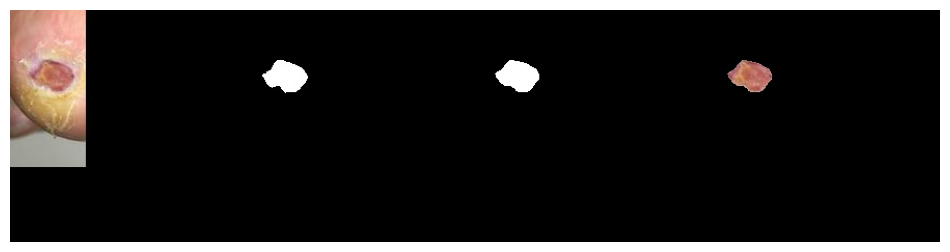


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 8min 11s, sys: 6min 26s, total: 14min 38s
Wall time: 11min 21s


In [11]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_val_loss', 'epoch_train_iou', 'epoch_val_iou', 'epoch_train_dice', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:41, Best_IOU:0.7335, Best_DiceScore:0.8300


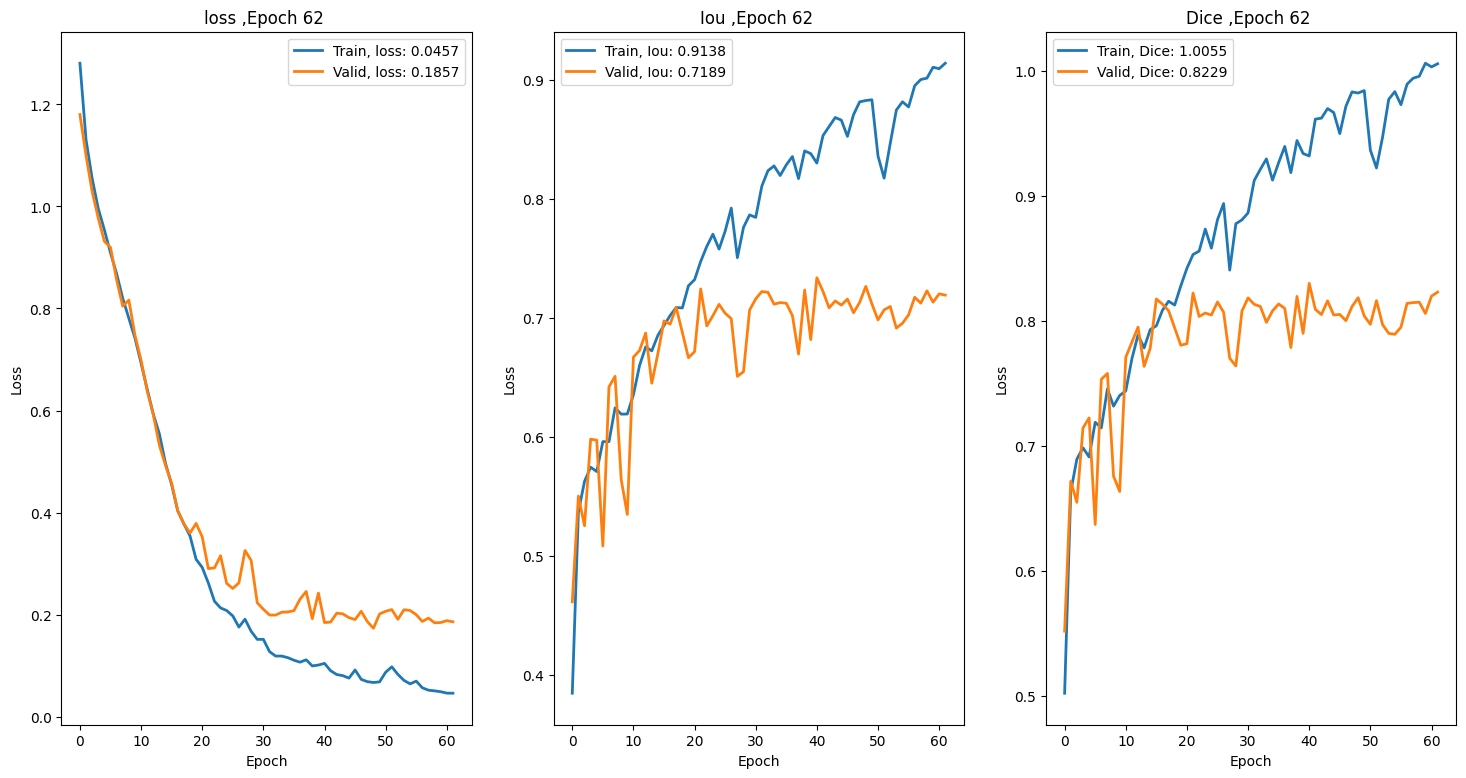

In [12]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()